This is an interactive notebook that enables image generation directly from physical parameters using machine learning.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import torch
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [4]:
#Load in the best-performing models

RandomForestRegressor = torch.load("src/RFR.h5") #Random forest regressor that we use to map physical parameters to position in the latent space
ae_model = torch.load("src/ae_CPU.h5") #autoencoder model that we use to go from latent space values to predicted image
RandomForestClassifier = torch.load("src/RFC.h5") #Random forest classifier that we use to predict whether or not a given combination of parameters describes an edge-on disk


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() and gpu else "cpu") #Use a GPU if available and a CPU if not

In [6]:
def gen_ML_img(params): #generate an image from a set of physical parameters using our trained machine learning models
    test_pred = RandomForestRegressor.predict([params]) #predict the latent space values that corespond to the inputted physical parameters
    z_test = np.array(test_pred) #array of predicted latent space values
    z_test_float= torch.from_numpy(z_test).float() #convert to float array, make it a pytorch array
    z_test_gpu = z_test_float.to(device=device) #port to GPU if possible, keep on CPU if not
    x = ae_model.decode(z_test_gpu) #predict image from latent space values using the decoder side of the autoencoder
    x = x.to(device='cpu') #port to CPU
    x = x.detach().numpy() 
    model = x
    mod_use = x[0,0,:,:]
    return mod_use

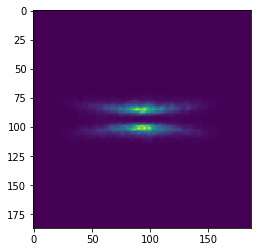

In [7]:
#set the physical parameter values

dust_mass = 5.95e-04 #Solar Masses
Rc = 264 #AU
flaring_exp = 1.219
H0 = 5.30 #AU
Rin = 2.1 #AU
sd_exp = -1.38
a_max = 100. #microns
inc = 90.0 #degrees

params = [np.log10(dust_mass), np.log10(Rc), flaring_exp, H0, np.log10(Rin), sd_exp, a_max, inc] 

#generate and show the ML image
plt.imshow(gen_ML_img(params))
plt.show()

In [8]:
def gen_img_widget(log_mdust, log_Rc, f_exp, H0, log_Rin, sd_exp, log_amax, inc):
    test_pred = RandomForestRegressor.predict([[log_mdust, log_Rc, f_exp, H0, log_Rin, sd_exp, log_amax, inc]])
    z_test = np.array(test_pred) #array of predicted latent space values
    z_test_float= torch.from_numpy(z_test).float() #convert to float array, make it a pytorch array
    z_test_gpu = z_test_float.to(device=device) #send to GPU
    x = ae_model.decode(z_test_gpu) #predicted image from latent space values using ML decoder
    x = x.to(device='cpu') #send to CPU
    x = x.detach().numpy() 
    plt.imshow(np.sqrt(x[0,0,:,:]), origin='lower')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    edge_on=RandomForestClassifier.predict([[log_mdust, log_Rc, f_exp, H0, log_Rin, sd_exp, log_amax, inc]])
    if edge_on==1:
        print("Edge-on")
    elif edge_on==0:
        print("Not edge-on (image may not be accurate!)")
    
cmb_w = interact(gen_img_widget, log_mdust = (-7,-3), log_Rc=(1,2.477,0.1), f_exp=(1,1.3,0.01), H0=(5,20,1), log_Rin=(-1,1,0.1), sd_exp=(-1.5,0,0.1), log_amax=(1,4,0.1),  inc = (45,90,1))

interactive(children=(IntSlider(value=-5, description='log_mdust', max=-3, min=-7), FloatSlider(value=1.700000…